In [38]:
import os
import sys
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [39]:
cwd = os.getcwd()
# Find and import config file
config_path = os.getcwd()

sys.path.append(config_path)
import config

In [40]:
database = config.database
central_banks = config.central_banks
training_data = os.path.join(database, "Training Data")
fed_docs = config.fed_docs
ecb_docs = config.ecb_docs

In [41]:
sentiment = pd.date_range(start="1/1/1999", end="1/1/2024", freq="D")
sentiment = pd.DataFrame(sentiment, columns=["date"])

In [42]:
# HP Filter

# url_map = pd.read_csv(os.path.join(cwd, "url_map.csv"))

# for i in range(len(url_map)):
#     if url_map["central bank"][i] == "fed" and url_map["document"][i] == "speeches":
#         speeches = pd.read_csv(url_map["finbert_url"][i])

# speeches["date"] = pd.to_datetime(speeches["date"], format='%Y%m%d')

# fed_speech = speeches.copy(deep=True)

# fed_speech = fed_speech[["date", "sentiment"]]
# fed_speech = fed_speech.rename(columns={"sentiment": "fed_speech_sentiment"})
# fed_speech["date"] = pd.to_datetime(fed_speech["date"])

# fed_speech = fed_speech.resample("Q", on="date").mean().reset_index()

# filter_df = fed_speech.copy(deep=True)
# filter_df = filter_df[["date", "fed_speech_sentiment"]]

# cycle, trend = sm.tsa.filters.hpfilter(filter_df["fed_speech_sentiment"], 1600)

# filter_df["fed_speech_sentiment_cycle"] = cycle
# filter_df["fed_speech_sentiment_trend"] = trend

# filter_df = filter_df[["date", "fed_speech_sentiment_cycle"]]
# fed_speech = fed_speech.drop(columns=["fed_speech_sentiment"])
# filter_df = filter_df.rename(
#     columns={"fed_speech_sentiment_cycle": "fed_speech_sentiment"}
# )
# fed_speech = pd.merge(fed_speech, filter_df, on="date", how="left")
# fed_speech = fed_speech.groupby("date").mean().reset_index()

# sentiment = pd.merge(sentiment, fed_speech, how="left", left_on="date", right_on="date")

In [43]:
url_map = pd.read_csv(os.path.join(cwd, "url_map.csv"))

for i in range(len(url_map)):
    sent = pd.read_csv(url_map["finbert_url"][i])
    sent = sent[["date", "sentiment"]]
    sent = sent.rename(columns={"sentiment": url_map["document"][i] + "_sentiment"})
    sent["date"] = pd.to_datetime(sent["date"])
    sent = sent.groupby("date").mean().reset_index()

    sentiment = pd.merge(sentiment, sent, how="left", left_on="date", right_on="date")

In [44]:
# Forward fill all NA data in the sentiment DataFrame
sentiment.ffill(inplace=True)

print(sentiment.head())

        date  statements_sentiment  minutes_sentiment  beigebooks_sentiment  \
0 1999-01-01                   NaN                NaN                   NaN   
1 1999-01-02                   NaN                NaN                   NaN   
2 1999-01-03                   NaN                NaN                   NaN   
3 1999-01-04                   NaN                NaN                   NaN   
4 1999-01-05                   NaN                NaN                   NaN   

   fed_speeches_sentiment  economic bulletins_sentiment  \
0                     NaN                           NaN   
1                     NaN                           NaN   
2               -0.146341                           NaN   
3                0.006579                           NaN   
4                0.006579                           NaN   

   monetary policy accounts_sentiment  press conferences_sentiment  \
0                                 NaN                          NaN   
1                             

In [45]:
# Calculate 90-day moving average for all sentiment columns
sentiment_columns = sentiment.columns.drop("date")
for column in sentiment_columns:
    sentiment[f"{column}_90d_ma"] = sentiment[column].rolling(window=90).mean()

print(sentiment.head())

        date  statements_sentiment  minutes_sentiment  beigebooks_sentiment  \
0 1999-01-01                   NaN                NaN                   NaN   
1 1999-01-02                   NaN                NaN                   NaN   
2 1999-01-03                   NaN                NaN                   NaN   
3 1999-01-04                   NaN                NaN                   NaN   
4 1999-01-05                   NaN                NaN                   NaN   

   fed_speeches_sentiment  economic bulletins_sentiment  \
0                     NaN                           NaN   
1                     NaN                           NaN   
2               -0.146341                           NaN   
3                0.006579                           NaN   
4                0.006579                           NaN   

   monetary policy accounts_sentiment  press conferences_sentiment  \
0                                 NaN                          NaN   
1                             

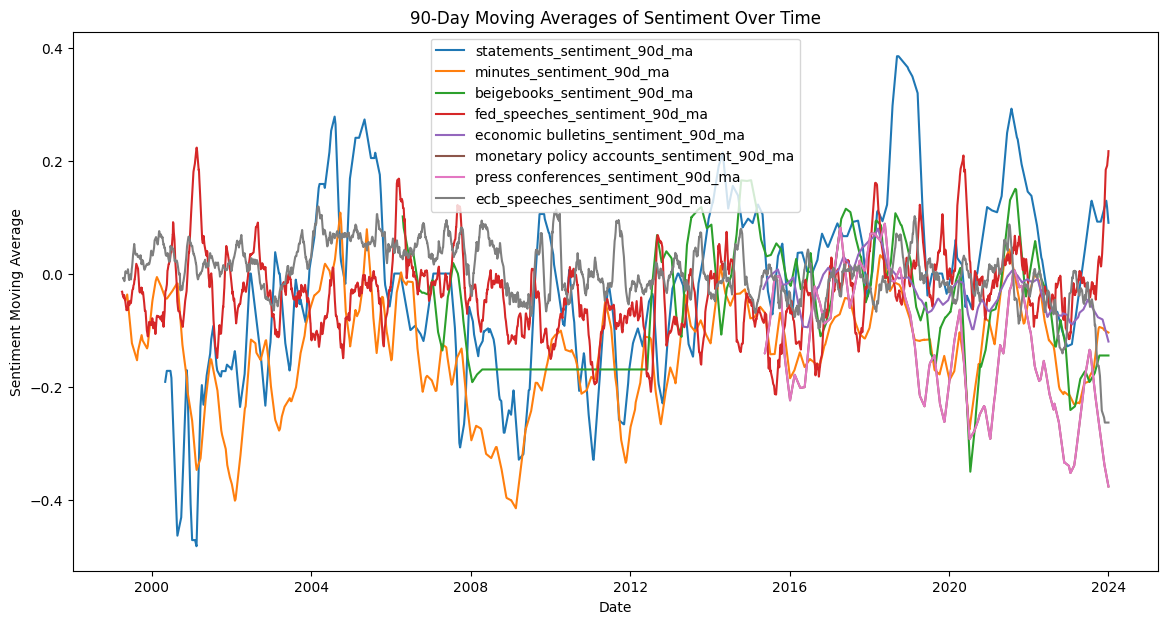

In [46]:
# Plotting the moving averages over time
plt.figure(figsize=(14, 7))

for column in sentiment_columns:
    plt.plot(sentiment['date'], sentiment[f'{column}_90d_ma'], label=f'{column}_90d_ma')

plt.xlabel('Date')
plt.ylabel('Sentiment Moving Average')
plt.title('90-Day Moving Averages of Sentiment Over Time')
plt.legend()
plt.show()

In [47]:
# Calculate daily average of all sentiment data, ignoring moving averages
sentiment_columns_no_ma = [col for col in sentiment_columns if not col.endswith('_90d_ma')]
sentiment['daily_average_sentiment'] = sentiment[sentiment_columns_no_ma].mean(axis=1)

print(sentiment[['date', 'daily_average_sentiment']].head())

        date  daily_average_sentiment
0 1999-01-01                      NaN
1 1999-01-02                      NaN
2 1999-01-03                -0.146341
3 1999-01-04                 0.006579
4 1999-01-05                 0.006579


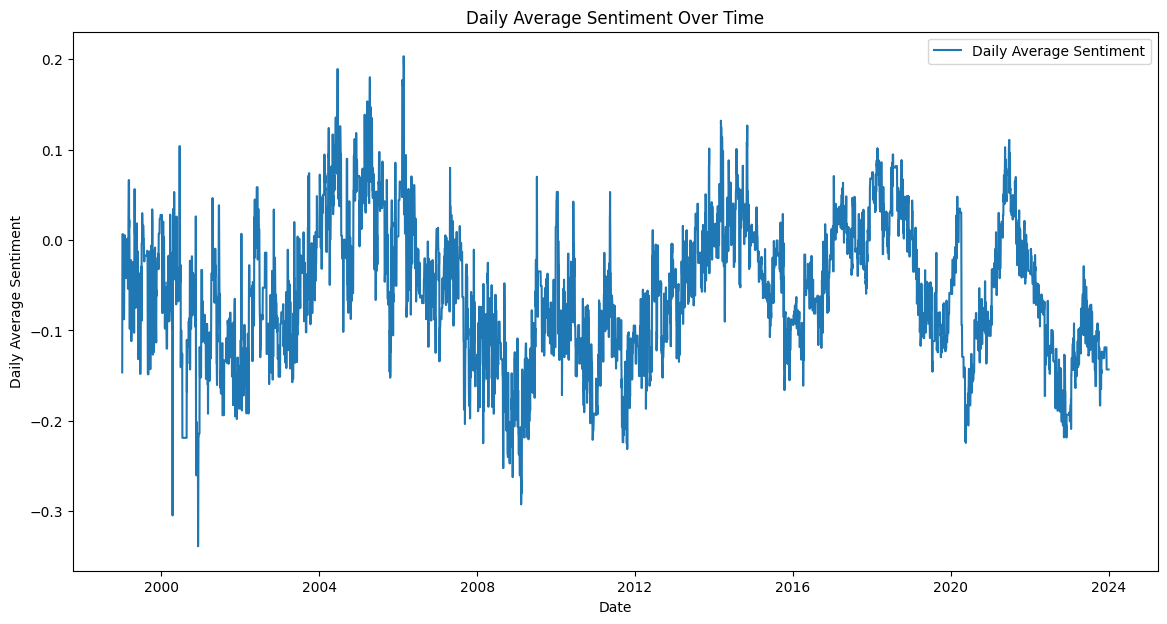

In [48]:
plt.figure(figsize=(14, 7))

plt.plot(sentiment['date'], sentiment['daily_average_sentiment'], label='Daily Average Sentiment')

plt.xlabel('Date')
plt.ylabel('Daily Average Sentiment')
plt.title('Daily Average Sentiment Over Time')
plt.legend()
plt.show()